## Prerequisites

In [ ]:
!pip install -q pandas seaborn matplotlib scikit-learn requests

In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import math
import base64
import requests

## Downloading and Importing the Vacation Preference Dataset From Kaggle

In [2]:
# Dataset download link
# https://www.kaggle.com/datasets/jahnavipaliwal/mountains-vs-beaches-preference

dataset = pd.read_csv("/content/mountains_vs_beaches_preferences.csv")
print(dataset.dtypes)
dataset.head()


Age                        int64
Gender                    object
Income                     int64
Education_Level           object
Travel_Frequency           int64
Preferred_Activities      object
Vacation_Budget            int64
Location                  object
Proximity_to_Mountains     int64
Proximity_to_Beaches       int64
Favorite_Season           object
Pets                       int64
Environmental_Concerns     int64
Preference                 int64
dtype: object


,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,56,male,71477,bachelor,9,skiing,2477,urban,175,267,summer,0,1,1
1,69,male,88740,master,1,swimming,4777,suburban,228,190,fall,0,1,0
2,46,female,46562,master,0,skiing,1469,urban,71,280,winter,0,0,1
3,32,non-binary,99044,high school,6,hiking,1482,rural,31,255,summer,1,0,1
4,60,female,106583,high school,5,sunbathing,516,suburban,23,151,winter,1,1,0


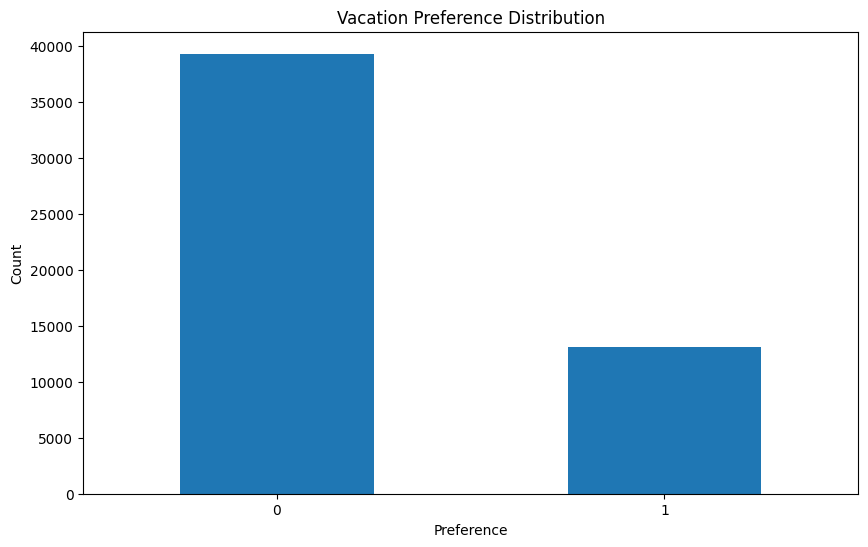

In [ ]:
dataset['Preference'].value_counts().plot(kind='bar',
                                          figsize=(10, 6),
                                          title='Vacation Preference Distribution')

plt.xlabel('Preference')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate labels for better readability
plt.show()

## Inserting Vacation Preference Dataset into GridDB Cloud

### Establishing a Connection with GridDB GridDB Cloud

In [ ]:
username = "your_griddb_cloud_user_name"
password = "your_griddb_cloud_password"

url = "your_griddb_cloud_url/checkConnection"

credentials = f"{username}:{password}"
encoded_credentials = base64.b64encode(credentials.encode()).decode()

headers = {
    'Content-Type': 'application/json',  # Added this header to specify JSON content
    'Authorization': f'Basic {encoded_credentials}',
    'User-Agent': 'PostmanRuntime/7.29.0'
}

response = requests.get(url, headers=headers)

print(response.status_code)
print(response.text)


200



### Create Container for User Vacation Preference Dataset in GridDB Cloud

In [ ]:
# Clean column names to remove spaces or forbidden characters in the GridDB container
dataset.columns = [col.strip().replace(" ", "_") for col in dataset.columns]

# Mapping pandas dtypes to GridDB types
type_mapping = {
    'int64': "LONG",
    'float64': "DOUBLE",
    'bool': "BOOL",
    'datetime64': "TIMESTAMP",
    'object': "STRING",
    'category': "STRING"
}

# Generate the columns part of the payload dynamically
columns = []
for col, dtype in dataset.dtypes.items():
    griddb_type = type_mapping.get(str(dtype), "STRING")  # Default to STRING if unknown
    columns.append({
        "name": col,
        "type": griddb_type
    })

columns

[{'name': 'Age', 'type': 'LONG'},
 {'name': 'Gender', 'type': 'STRING'},
 {'name': 'Income', 'type': 'LONG'},
 {'name': 'Education_Level', 'type': 'STRING'},
 {'name': 'Travel_Frequency', 'type': 'LONG'},
 {'name': 'Preferred_Activities', 'type': 'STRING'},
 {'name': 'Vacation_Budget', 'type': 'LONG'},
 {'name': 'Location', 'type': 'STRING'},
 {'name': 'Proximity_to_Mountains', 'type': 'LONG'},
 {'name': 'Proximity_to_Beaches', 'type': 'LONG'},
 {'name': 'Favorite_Season', 'type': 'STRING'},
 {'name': 'Pets', 'type': 'LONG'},
 {'name': 'Environmental_Concerns', 'type': 'LONG'},
 {'name': 'Preference', 'type': 'LONG'}]

In [ ]:
url = "your_griddb_cloud_url/containers"
container_name = "vacation_db"
# Create the payload for the POST request
payload = json.dumps({
    "container_name": container_name,
    "container_type": "COLLECTION",
    "rowkey": True,  # Assuming the first column as rowkey
    "columns": columns
})


# Make the POST request to create the container
response = requests.post(url, headers=headers, data=payload)

# Print the response
print(f"Status Code: {response.status_code}")


Status Code: 201


### Adding Data to GridDB Cloud Container

In [ ]:
url = f"your_griddb_cloud_url/containers/{container_name}/rows"


# Convert dataset to list of lists (row-wise) with proper formatting
def format_row(row):
    formatted = []
    for item in row:
        if pd.isna(item):
            formatted.append(None)  # Convert NaN to None
        elif isinstance(item, bool):
            formatted.append(str(item).lower())  # Convert True/False to true/false
        elif isinstance(item, (int, float)):
            formatted.append(item)  # Keep integers and floats as they are
        else:
            formatted.append(str(item))  # Convert other types to string
    return formatted

# Prepare rows with correct formatting
rows = [format_row(row) for row in dataset.values.tolist()]

# Create payload as a JSON string
payload = json.dumps(rows)

# Make the PUT request to add the rows to the container
response = requests.put(url, headers=headers, data=payload)

# Print the response
print(f"Status Code: {response.status_code}")
print(f"Response Text: {response.text}")


Status Code: 200
Response Text: {"count":52444}


## User Vacation Preference Prediction Using Machine Learning

### Retrieving Data From GridDB

In [ ]:

url = f"your_griddb_cloud_url/containers/{container_name}/rows"

# Define the payload for the query
payload = json.dumps({
    "offset": 0,           # Start from the first row
    "limit": 10000,         # Limit the number of rows returned
    "condition": "",       # No filtering condition (you can customize it)
    "sort": ""             # No sorting (you can customize it)
})

# Make the POST request to read data from the container
response = requests.post(url, headers=headers, data=payload)

# Check response status and print output
print(f"Status Code: {response.status_code}")
if response.status_code == 200:
    try:
        data = response.json()
        print("Data retrieved successfully!")

        # Convert the response to a DataFrame
        rows = data.get("rows", [])
        vacation_dataset = pd.DataFrame(rows, columns=[col for col in dataset.columns])


    except json.JSONDecodeError:
        print("Error: Failed to decode JSON response.")
else:
    print(f"Error: Failed to query data from the container. Response: {response.text}")

vacation_dataset.head()

Status Code: 200
Data retrieved successfully!


,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,56,male,62612,bachelor,9,sunbathing,2632,urban,219,295,spring,0,0,0
1,69,non-binary,31116,high school,5,swimming,4043,suburban,277,205,spring,0,0,0
2,46,male,69132,bachelor,6,sunbathing,3513,suburban,35,49,spring,0,0,0
3,32,male,87325,master,1,hiking,2140,rural,108,291,fall,0,0,1
4,60,male,71654,bachelor,0,skiing,555,urban,210,81,winter,1,0,0


### Preprocessing Data for Machine Learning Models

In [ ]:
categorical_columns = vacation_dataset.select_dtypes(include=['object']).columns.tolist()

# Convert categorical columns to dummies
dataset_encoded = pd.get_dummies(vacation_dataset, columns=categorical_columns, drop_first=True)

# Display the transformed dataset
dataset_encoded.head()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Gender_male,...,Education_Level_high school,Education_Level_master,Preferred_Activities_skiing,Preferred_Activities_sunbathing,Preferred_Activities_swimming,Location_suburban,Location_urban,Favorite_Season_spring,Favorite_Season_summer,Favorite_Season_winter
0,56,62612,9,2632,219,295,0,0,0,True,...,False,False,False,True,False,False,True,True,False,False
1,69,31116,5,4043,277,205,0,0,0,False,...,True,False,False,False,True,True,False,True,False,False
2,46,69132,6,3513,35,49,0,0,0,True,...,False,False,False,True,False,True,False,True,False,False
3,32,87325,1,2140,108,291,0,0,1,True,...,False,True,False,False,False,False,False,False,False,False
4,60,71654,0,555,210,81,1,0,0,True,...,False,False,True,False,False,False,True,False,False,True


### Predicting User Vacation Preference with Machine Learning

In [ ]:
X = dataset_encoded.drop(columns=['Preference'])
y = dataset_encoded['Preference']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initialize and train the RandomForestClassifier
rfc_model = RandomForestClassifier(random_state=42, n_estimators=1000)
rfc_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rfc_model.predict(X_train)
y_test_pred = rfc_model.predict(X_test)

# Compute accuracy using sklearn.metrics.accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.8182


Classification Report:

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.33      0.50         3

    accuracy                           0.82        11
   macro avg       0.90      0.67      0.69        11
weighted avg       0.85      0.82      0.78        11



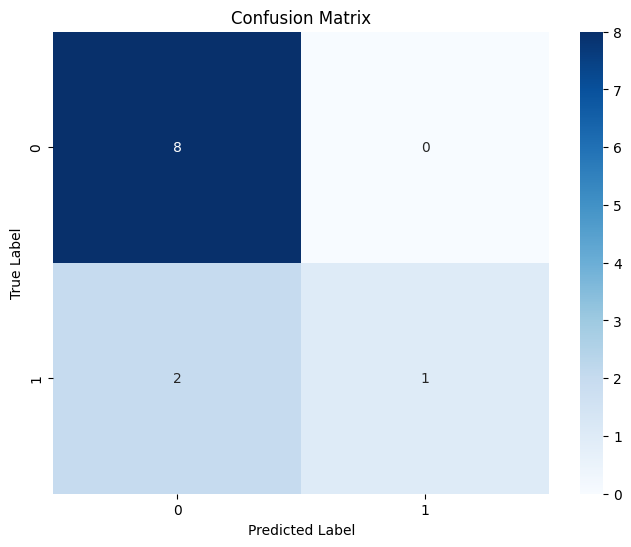

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rfc_model.classes_, yticklabels=rfc_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()